In [1]:
import rich

In [2]:
from datasets import load_dataset

/dfs/data/uv-venv/modelscope/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_path = "/dfs/data/work/hardtry/data/looptool/LoopTool_grpo_training_data.json"

In [4]:
ds = load_dataset("json",data_files=data_path,split="train")

In [5]:
model_path = "/dfs/data/models/Qwen3-4B-Instruct-2507/"

In [6]:
from transformers import AutoTokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [8]:
import re
import json

def parse_qwen3_template_to_messages(template_str):
    """
    将经过 Qwen3-4B-Instruct-2507 模板处理后的字符串还原为 messages 列表格式。
    """
    messages = []
    
    # 1. 匹配所有 <|im_start|>{role}\n{content}<|im_end|> 结构
    # 注意：末尾可能有一个未闭合的 <|im_start|>assistant 用于生成引导
    block_pattern = re.compile(r'<\|im_start\|>(\w+)\n(.*?)(?=<\|im_end\|>|$)', re.DOTALL)
    blocks = block_pattern.findall(template_str)

    for role, body in blocks:
        body = body.strip()
        messages.append({"role":role,"content":body})
    return messages


In [9]:
def map_fn(example):
    prompt = tokenizer.apply_chat_template([
                {"role":"system","content":example['instruction']},
                {"role":"user","content":example['input']},
                {"role":"assistant","content":example['output']},
            ],
            add_generation_prompt=False,
            tokenize=False
        )
    new_prompt = prompt.replace("# Tools","\n# Tools")
    messages = parse_qwen3_template_to_messages(new_prompt)
    tokens = tokenizer.encode(new_prompt, add_special_tokens=False)
    token_length = len(tokens)
    return {
        "messages": messages,
        "length": token_length
    }

In [10]:
ds=ds.map(map_fn,remove_columns=["instruction","input","output"])

Map: 100%|██████████| 23040/23040 [04:39<00:00, 82.58 examples/s] 


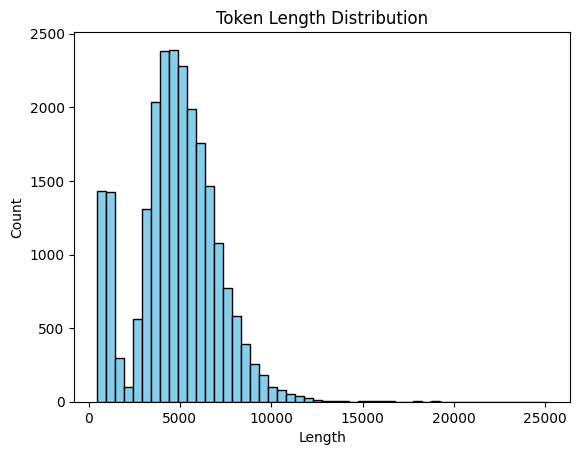

In [11]:
import matplotlib.pyplot as plt

plt.hist(ds["length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Token Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [13]:
ds = ds.filter(lambda x: x["length"] <= 10240)

Filter: 100%|██████████| 23040/23040 [00:01<00:00, 12016.78 examples/s]


In [14]:
with open(data_path.rsplit('/',1)[0]+'/looptool_openai_messages_fc.jsonl', 'w', encoding='utf-8') as f:
    for entry in ds:
        # entry 现在是一个字典，包含了 map_fn 返回的 "messages" 列
        # 使用 ensure_ascii=False 来确保中文不被转义为 \uXXXX
        json_record = json.dumps(entry, ensure_ascii=False)
        f.write(json_record + '\n')